<h1 style="text-align:center">Principal Component Analysis in Planetary Ultraviolet Spectral Analysis</h1>
<p style="text-align:center; font-style: italic; font-size: 20px">Daniel Lo, Maureen Palmer</p>

<h2>Introduction</h2>
<p>Principal Component Analysis (PCA) is a widely-used unsupervised data mining technique for identifying potentially physically important features in the data. In spectrography, PCA is often applied to images of large scenes where various regions of interest in the scene are expected to have significantly different spectral signatures that can be isolated with the technique. In our research with ultraviolet spectra in planetary contexts, this requirement appears to be satisfied, with many features arising from unique atomic or molecular electronic transitions. However, PCA is not used for data reduction in either of the teams we are in. Rather, data reduction is done using a least squares fit with spectral templates. These templates are picked based on prior expectations of what would be present in the spectra, and are based on laboratory measurements of absorption and emission cross-sections of various molecules. Unfortunately, good quality cross-sections are not available for many molecules because this laboratory work is so labor-intensive.  Titan's atmosphere in particular seems to have a nearly infinite variety of organic molecules, but a lot of these have not been observed in the lab and/or have not been observed at an appropriate temperature. We wonder if PCA would be able to isolate these spectral templates from the data itself, and if these PCA-derived templates could even prove to be more appropriate than those based on laboratory measurements due to their lack of experimental uncertainties and their automatic incorporation of instrument effects such as the point spread function.</p>
    
<p>In this project we apply PCA to two different types of data, from two different instruments at two different planetary bodies. The first comes from the Imaging UltraViolet Spectrograph (IUVS) on board Mars Atmosphere and Volatile EvolutioN (MAVEN) spacecraft, which has been in orbit around Mars since 2014. The second comes from the UltraViolet Imaging Spectrograph Subsystem (UVIS) on board the Cassini spacecraft, which arrived at the Saturnian system in 2004 and eventually ended its mission in the atmosphere of Saturn in 2017. The UVIS observations are of Titan, Saturn's largest moon.</p>

<h2>MAVEN IUVS</h2>
<p>IUVS took a variety of observations of the Martian atmosphere in the FUV (110--190 nm) and MUV channels (180--340 nm) as the MAVEN spacecraft orbited the planet [McClintock et al., 2014]. Here we focus on limb dayglow observations taken in the FUV during the periapse segment of the eccentric MAVEN orbit. These dayglow FUV spectra show features arising from fluorescence of various atmospheric species under solar UV irradiation, and electronically excited products produced by photochemical reactions driven by solar UV. </p>

<p>IUVS uses a 1024x1024 CMOS detector, with one dimension corresponding to the axis of the slit and the other the spectral dispersion direction. At each orbit, the instrument was pointed at the dayside limb of the Martian atmosphere, and a mirror rotated to allow the slit to sample different tangent altitudes of the limb. For these periapse limb dayglow observations, the 1024x1024 images are rebinned into images with 7 spatial bins and 200 spectral bins. In the standard processing pipeline, the wavelength scale is calibrated with firstly a Gaussian fit to determine the centroid of the H Lyman alpha emission for each image, and then a calculation using the known dispersion of the instrument. Our analysis picks off from this stage of data processing, or Level 1b. </p>

<p>We limit our dataset to solar zenith angles (SZA) at the tangent point of less than 60$^\circ$, tangent altitudes of the line of sight between 80 and 160 km, and MAVEN orbits 2000--3000 (Oct 2015--Apr 2016). We also cut out the edges of the images in the spectral dimension where the sensitivity is low, limiting our spectral range to 115--170 nm.</p>

<p>As with all codes, we first import the relevant Python packages.</p>

In [1]:
import numpy as np
import csv
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
plt.rcParams.update({'font.size': 16})
from sklearn.decomposition import PCA, NMF

<p>IUVS Level 1b periapse limb observations are available on the Planetary Data System at <a href="https://atmos.nmsu.edu/data_and_services/atmospheres_data/MAVEN/limb.html"> https://atmos.nmsu.edu/data_and_services/atmospheres_data/MAVEN/limb.html</a> under "Calibrated Data". While IUVS data is nominally in the FITS format, we have extracted the relevant data and compiled them into CSV files for ease of use in this project:
<ul>
    <li>iuvs_wavenm.csv: Wavelength scale in nm for IUVS data
    <li>iuvs_data.csv: IUVS spectra. Each row represents one spectrum. First column is line-of-sight tangent altitude for the spectrum, second column is the SZA at the tangent point, and subsequent columns are the uncalibrated spectral data.
    <li>iuvs_templates.csv: spectral templates from the IUVS processing pipeline
</ul>
</p>

In [2]:
# Read in CSV data files
wavenm = np.zeros(200)
with open('iuvs_wavenm.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    i_wav = 0
    for wav in csvReader:
        wavenm[i_wav] = float(wav[0])
        i_wav += 1
wavenm = wavenm[23:192]

templates = np.zeros((41,200))
with open('iuvs_templates.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    i_spec = 0
    for row in csvReader:
        for i_spe in range(200):
            templates[i_spec,i_spe] = float(row[i_spe])
        i_spec += 1
templates = templates[:,23:192]

data = np.zeros((67427,169))
sza = np.zeros(67427)
alt = np.zeros(67427)
with open('iuvs_data.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    i_spec = 0
    for row in csvReader:
        alt[i_spec] = float(row[0])
        sza[i_spec] = float(row[1])
        for i_spe in range(169):
            data[i_spec,i_spe] = float(row[i_spe+25])
        # Normalize to unity brightness
        data[i_spec,:] = data[i_spec,:]/sum(data[i_spec,:])
        i_spec += 1

data_zero = np.clip(data, 0, 1); # data with zeroed negative values

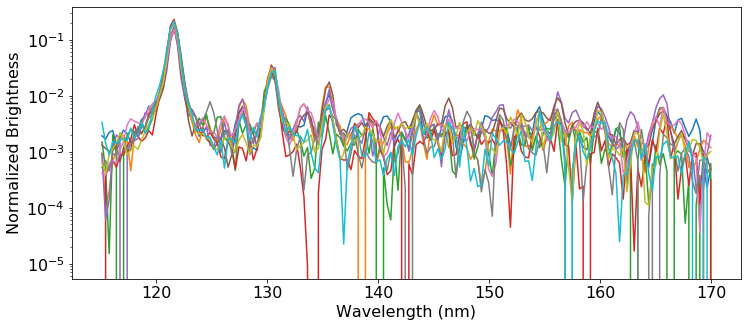

In [3]:
# Plot 10 random spectra
fig = plt.figure(figsize=(12, 5))
for i in np.random.randint(0,67427,10):
    plt.semilogy(wavenm,data[i,:]);
plt.xlabel('Wavelength (nm)');
plt.ylabel('Normalized Brightness');

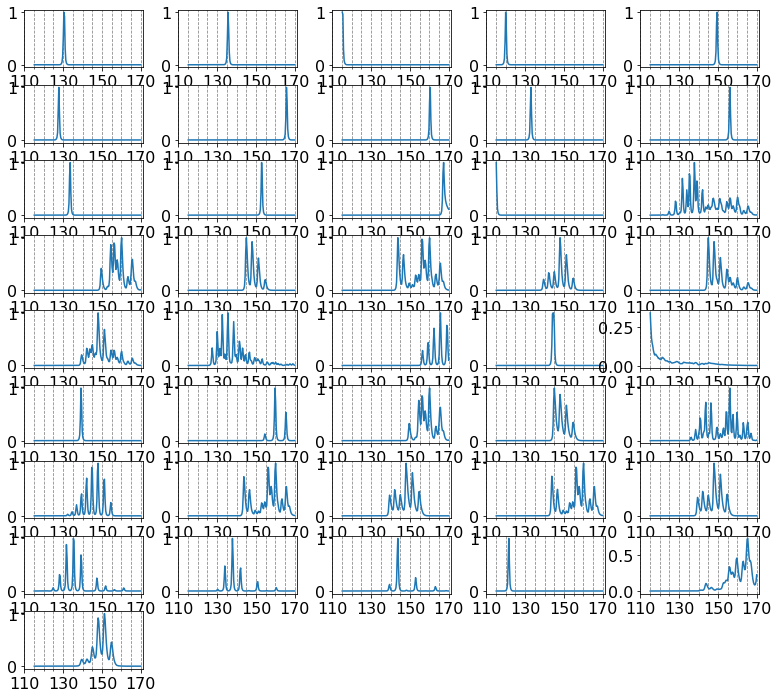

In [4]:
# Plot Spectral Templates
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.3,
                    bottom=0.1, top=0.95, hspace=0.3)

for i_comp in range(41):
    ax = fig.add_subplot(10,5,i_comp+1)
    ax.plot(wavenm, templates[i_comp,:]);
    ax.set_xticks(np.arange(110, 171, 20))
    ax.set_xlim((110,171))
    plt.grid(b=True, which='both', color='#888888', axis='x', linestyle='--')
    ax.xaxis.set_minor_locator(AutoMinorLocator())

<p>From the spectra above, we can immediately see that the brightest feature is the H Lyman alpha at 121.6 nm, followed by the O I feature at 130.4 nm and another O I feature at 135.6 nm.</p>

<p>We then perform a PCA on the spectra to see if we can obtain these same features that we can see by eye, and other less obvious features in the data. Each PCA eigenspectrum is also plotted with IUVS pipeline templates for comparison.</p>

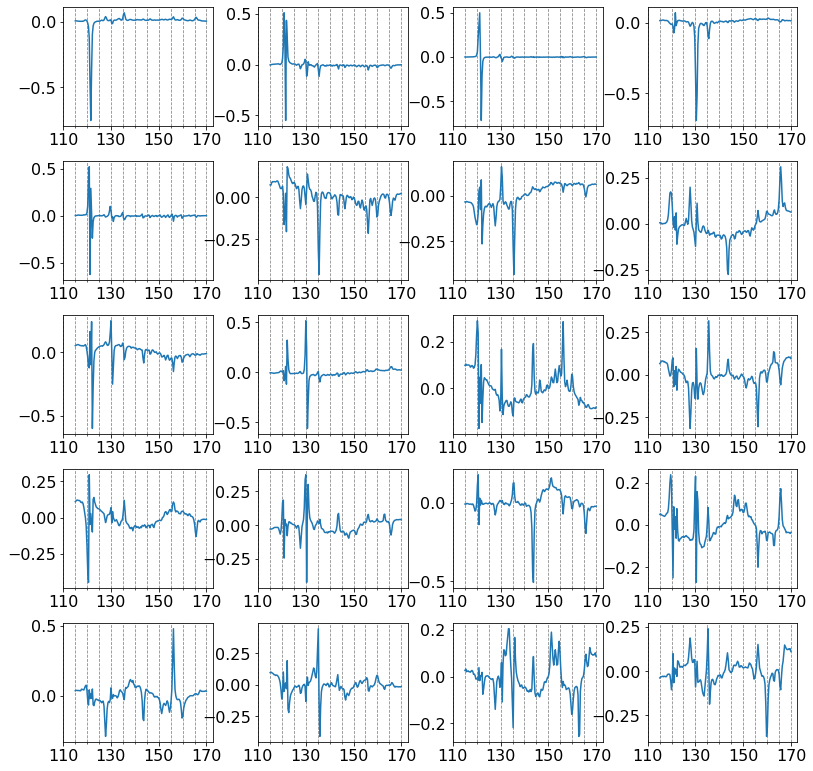

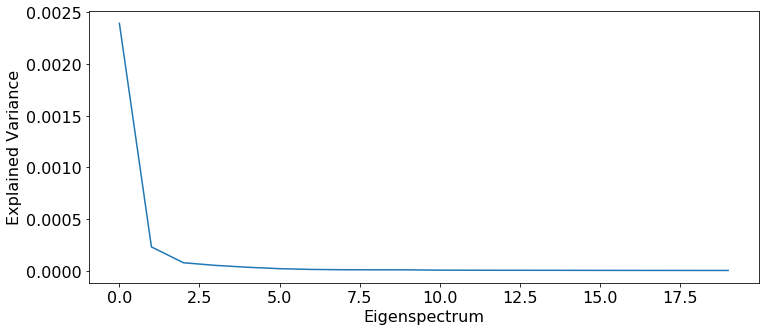

In [5]:
# Principal Component Analysis

pca = PCA(n_components=20);
pca.fit(data);

# Plot PCA results

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.3,
                    bottom=0.1, top=0.95, hspace=0.3)

for i_comp in range(20):
    ax = fig.add_subplot(5,4,i_comp+1)
    ax.plot(wavenm, pca.components_[i_comp,:]);
    ax.set_xticks(np.arange(110, 171, 20))
    plt.grid(b=True, which='both', color='#888888', axis='x', linestyle='--')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    
fig = plt.figure(figsize=(12, 5))
plt.plot(pca.explained_variance_);
plt.xlabel('Eigenspectrum');
plt.ylabel('Explained Variance');

<p>We find that many of the eigenspectra are dominated by the H Lyman alpha feature. The largest eigenspectrum has a clear (though inverted) H Lyman alpha, while in many of the other eigenspectra the feature shows up as zig-zag patterns. This zig-zag pattern is likely due to the variance of the instrument PSF across the 7 spatial bins, resulting in the H Lyman alpha feature having different widths in different spectra. As we go to smaller eigenspectra, the number of "folds" on the zig-zag pattern increases, representing higher-order corrections to the instrument PSF. </p>

<p>Other than the H Lyman alpha, we can also see the two O I features showing up in many eigenspectra. Similar zig-zag patterns are visible for these features (e.g. eigenspectra 9 and 10 for O I 130.4 nm and eigenspectra 18 and 20 for O I 135.6 nm). </p>

<p>For other features, we can directly compare the eigenspectra with the IUVS spectral templates. Below we plot eigenvectors 6--9 with the spectral templates. These 4 eigenvectors have a high degree of additional structure beyond the 3 previously-discussed features. We can see that the eigenvectors share many peaks with the templates. However, physical interpretation is very difficult with the many spurious features and frequent "inversion" of the spectra. </p>

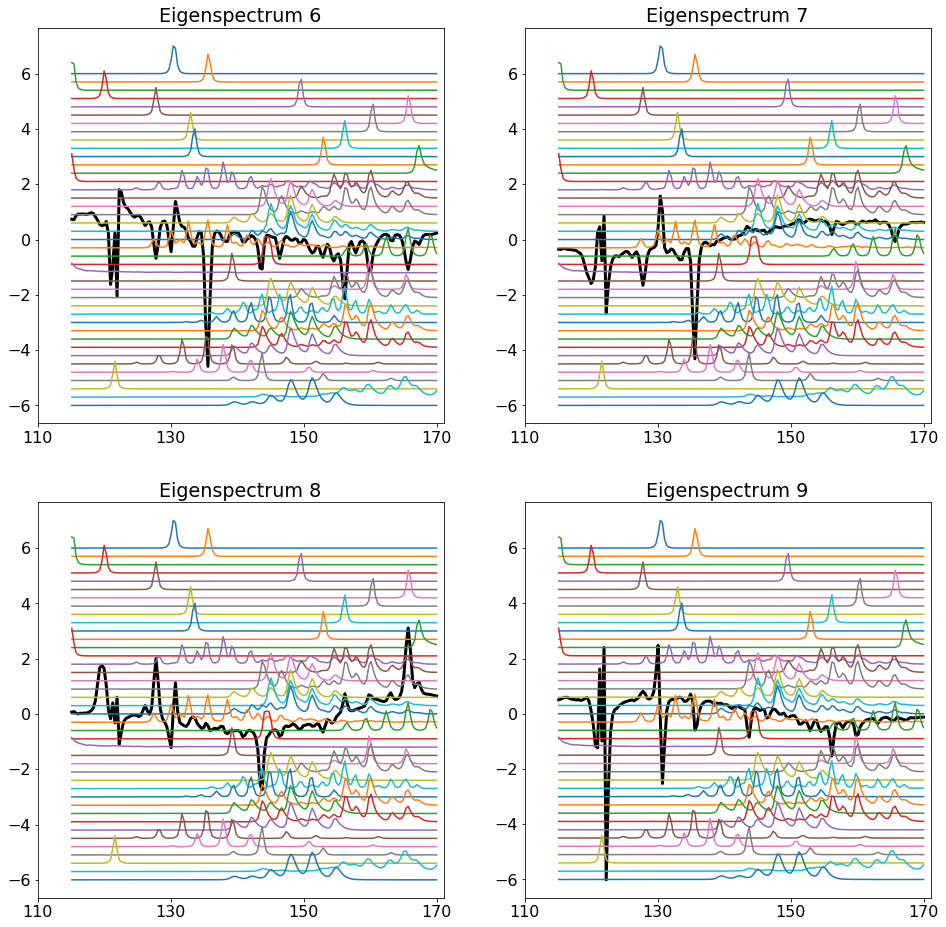

In [6]:
fig = plt.figure(figsize=(16, 16));

ax = fig.add_subplot(2,2,1)
ax.plot(wavenm, pca.components_[5,:]*10, 'k', linewidth=3);
for i_comp in range(41):
    ax.plot(wavenm, templates[i_comp,:]+6-i_comp*0.3);
ax.set_title('Eigenspectrum 6')
ax.set_xticks(np.arange(110, 171, 20))
ax.set_xlim((110,171));

ax = fig.add_subplot(2,2,2)
ax.plot(wavenm, pca.components_[6,:]*10, 'k', linewidth=3);
for i_comp in range(41):
    ax.plot(wavenm, templates[i_comp,:]+6-i_comp*0.3);
ax.set_title('Eigenspectrum 7')
ax.set_xticks(np.arange(110, 171, 20))
ax.set_xlim((110,171));

ax = fig.add_subplot(2,2,3)
ax.plot(wavenm, pca.components_[7,:]*10, 'k', linewidth=3);
for i_comp in range(41):
    ax.plot(wavenm, templates[i_comp,:]+6-i_comp*0.3);
ax.set_title('Eigenspectrum 8')
ax.set_xticks(np.arange(110, 171, 20))
ax.set_xlim((110,171));

ax = fig.add_subplot(2,2,4)
ax.plot(wavenm, pca.components_[8,:]*10, 'k', linewidth=3);
for i_comp in range(41):
    ax.plot(wavenm, templates[i_comp,:]+6-i_comp*0.3);
ax.set_title('Eigenspectrum 9')
ax.set_xticks(np.arange(110, 171, 20))
ax.set_xlim((110,171));

<p>One way to improve the interpretability of PCA components is to use a variant of traditional PCA --- Non-negative Matrix Factorization (NMF). Since spectral emissions are expected to be positive, the requirement of fully positive components for NMF allows for the convenient imposition of a natural constraint on the results. This constraint also minimizes the zig-zag artefact and inversion of spectra. </p>

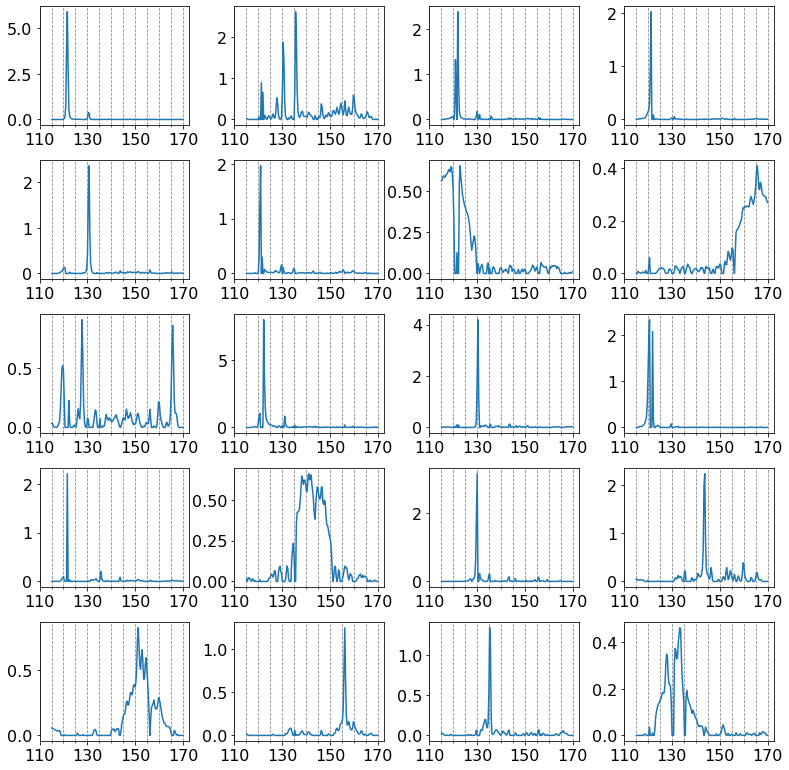

In [7]:
# Nonnegative Matrix Factorization

nmf = NMF(n_components=20);
nmf.fit(data_zero);

# Plot NMF results

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.3,
                    bottom=0.1, top=0.95, hspace=0.3)

for i_comp in range(20):
    ax = fig.add_subplot(5,4,i_comp+1)
    ax.plot(wavenm, nmf.components_[i_comp,:]);
    ax.set_xticks(np.arange(110, 171, 20))
    plt.grid(b=True, which='both', color='#888888', axis='x', linestyle='--')
    ax.xaxis.set_minor_locator(AutoMinorLocator())

<p>On quick inspection, we see that the NMF eigenspectra are much more interpretable than the PCA eigenspectra. The NMF eigenspectra are cleaner and more easily identifiable. Immediately, we can see that 8 of the top 20 eigenspectra are dominated by the H Lyman alpha emission --- another sign of the variable instrument PSF in the data. O I 130.4 nm appears in 3 of the eigenspectra and O I 135.6 nm appears in the 19th eigenspectrum. NMF is also able to identify the C I 156.1 nm emission in eigenspectrum 18. Eigenspectra 7, 8, 14, 17 and 20 are likely to come from a background continuum from the sum of the tails of multiple emissions. </p>

<p>Below, we plot two of the more structured eigenspectra, 2 and 9, against IUVS spectral templates for comparison.</p>

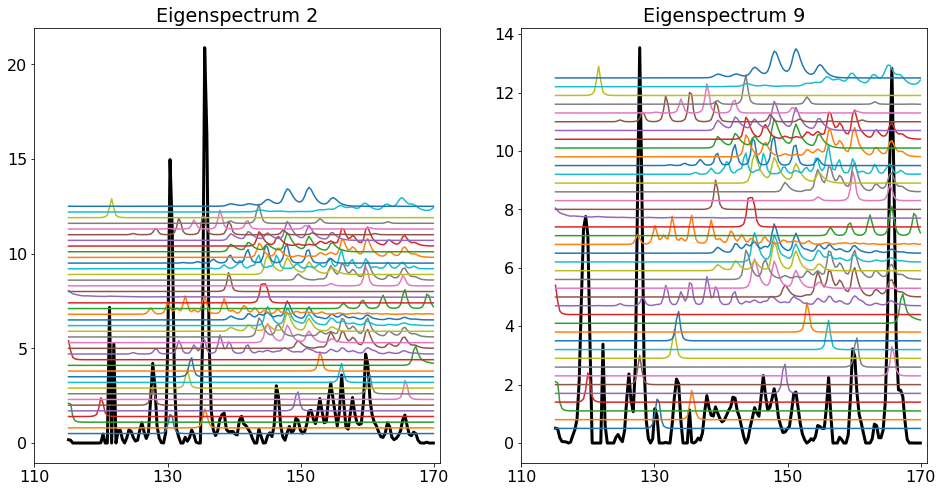

In [8]:
fig = plt.figure(figsize=(16, 8));

ax = fig.add_subplot(1,2,1)
ax.plot(wavenm, nmf.components_[1,:]*8, 'k', linewidth=3);
for i_comp in range(41):
    ax.plot(wavenm, templates[i_comp,:]+0.5+i_comp*0.3);
ax.set_title('Eigenspectrum 2')
ax.set_xticks(np.arange(110, 171, 20))
ax.set_xlim((110,171));

ax = fig.add_subplot(1,2,2)
ax.plot(wavenm, nmf.components_[8,:]*15, 'k', linewidth=3);
for i_comp in range(41):
    ax.plot(wavenm, templates[i_comp,:]+0.5+i_comp*0.3);
ax.set_title('Eigenspectrum 9')
ax.set_xticks(np.arange(110, 171, 20))
ax.set_xlim((110,171));

<p>We can see that many of the features in the two eigenspectra also show up in the templates. Although interpretation is easier with less spurious features and properly oriented spectra in NMF, there is still much mixing in the spectral features that constitute the eigenspectra. This mixing is expected --- although each spectral template describe a unique physical process, many of the processes are correlated (e.g. excited CO and C are both produced from CO$_2$, and so the intensities of the emissions will be correlated). While the correlations that show up with NMF are interesting, they are often divided up </p>

<h2>Cassini UVIS</h2>

<p>The spacecraft Cassini orbited Saturn from 2004 until 2017, when it was destroyed in a plunge into Saturn's atmosphere.  During this time, Cassini extensively observed Saturn and Saturn's many moons with a variety of instruments.  </p>

<p>Titan, Saturn's largest and most interesting moon, has a thick atmosphere primarily composed of molecular nitrogen (N$_2$) and methane (CH$_4$).  Photochemical reactions between these species lead to a nearly limitless variety of organic molecules present in Titan's atmosphere. </p>

<p>In this work, we use spectra from Cassini's UltraViolet Imaging Spectrograph (UVIS). These data were collected as Titan occulted the stars of Orion's belt.  In particular, the dataset we provide here is from an occultation of $\zeta$ Ori (Alnitak).  The raw data from these Cassini observations are available from NASA's Planetary Data System.  In the provided hdf5 data file, we have calculated transmission values from the raw data.  Each spectrum is from a different altitude. </p>

<p>Now, for the methods.  First, we import packages:</p>

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
plt.rcParams.update({'font.size': 16})
import h5py
from sklearn.decomposition import PCA, NMF
import f_wavelengths #This is another python script, provided for calculating the UVIS wavelength scale

Next, we read in the data from the hdf5 file and retrieve the wavelength scale.

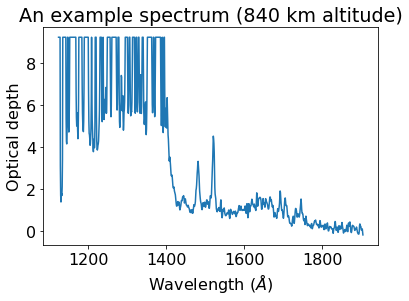

In [11]:
f = h5py.File('Titan_FUV_0_results_individual.hdf5', 'r')
trans = np.clip(np.asarray(f['trans']),1*10**-4,None) #This is an array containing the transmission spectra at every altitude
#Transmission array is clipped to deal with zeros
tau = -1*np.log(trans)[:,10:-10] #Optical depth. Edges removed to get rid of edge artefacts

wls=f_wavelengths.e_wavelength[10:-10]
plt.plot(wls,tau[320,:])
plt.title('An example spectrum (840 km altitude)')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Optical depth')
plt.show()

Note that some regions of the spectra are saturated at low altitudes, where methane becomes optically thick.

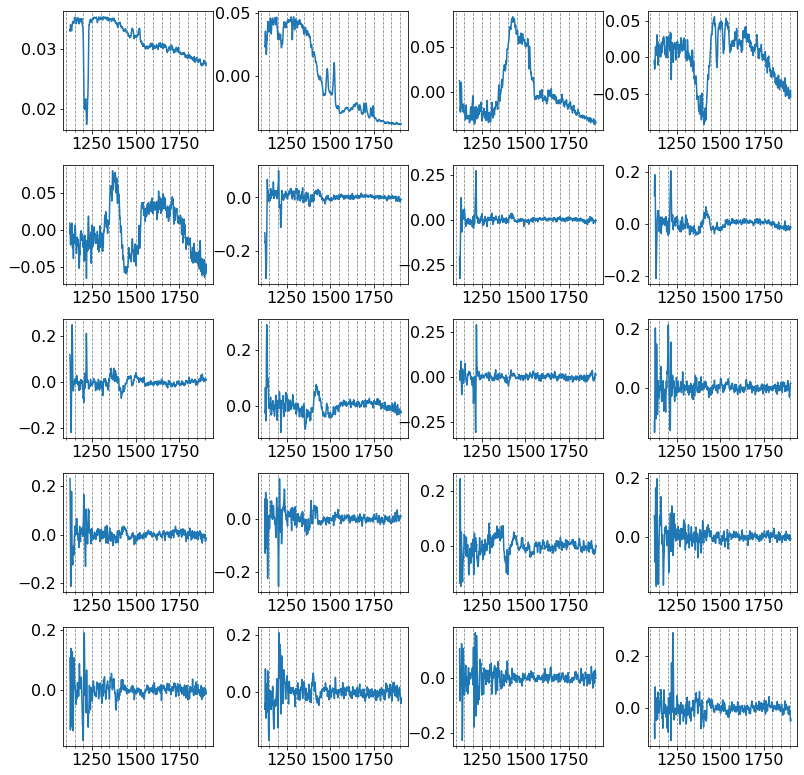

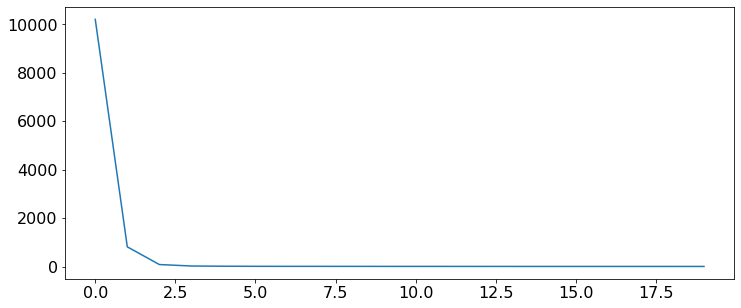

In [12]:
#Perform principal component analysis

pca = PCA(n_components=20);
pca.fit(tau);

# Plot PCA results

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.3,
                    bottom=0.1, top=0.95, hspace=0.3)

for i_comp in range(20):
    ax = fig.add_subplot(5,4,i_comp+1)
    ax.plot(wls, pca.components_[i_comp,:]);
    plt.grid(b=True, which='both', color='#888888', axis='x', linestyle='--')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    
fig = plt.figure(figsize=(12, 5))
plt.plot(pca.explained_variance_);

Essentially all of the variance between these spectra can be described by just
3 PCA components, which is very efficient.  However, these results do not seem to be very helpful from the perspective of studying variations in atmospheric composition with altitude.  As shown in the figure below, PCA component 1 shows a strong Lyman-$\alpha$ signal from stray light, along with two lines from acetylene in Titan's atmosphere.  Meanwhile, PCA component 2 contains the acetylene lines and a bit of Lyman-$\alpha$ again, a strong signal from methane, and lines from both diacetylene and ethylene.  This confusion is a problem because it means we cannot use these PCA components as templates for modeling the abundances of different species in Titan's atmophsere.  


Text(1595, -0.017, 'C$_4$H$_2$')

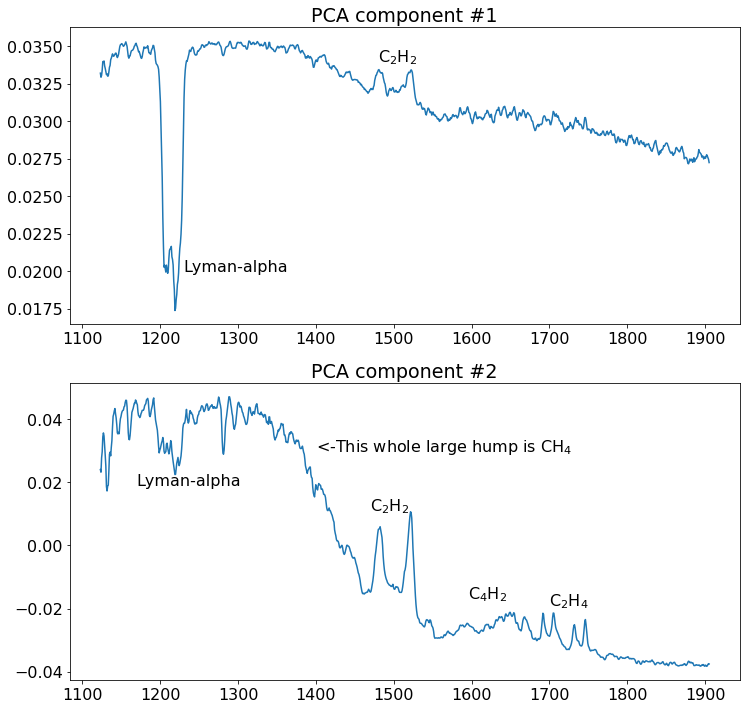

In [13]:
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(2,1,1)
ax1.set_title('PCA component #1')
ax1.plot(wls,pca.components_[0])
ax1.text(1230,0.02,'Lyman-alpha')
ax1.text(1480,0.0340,'C$_2$H$_2$')

ax2 = fig.add_subplot(2,1,2)
ax2.set_title('PCA component #2')
ax2.plot(wls,pca.components_[1])
ax2.text(1400,0.03,'<-This whole large hump is CH$_4$')
ax2.text(1170,0.019,'Lyman-alpha')
ax2.text(1470,0.011,'C$_2$H$_2$')
ax2.text(1700,-0.019,'C$_2$H$_4$')
ax2.text(1595,-0.017,'C$_4$H$_2$')

<h2>Conclusions</h2>
<p>Prior knowledge of spectroscopy is very useful for studying the spectra of planetary atmospheres, and unfortunately the unsupervised nature of PCA creates a lot of chaos.  This technique does not seem to work well for analyzing  spectra from an individual planetary body because different spectra of one atmosphere will all show approximately the same composition, so the axes of maximum variance do not really correlate with the spectral signatures of individual different species.  Furthermore, PCA seems to be pretty sensitive to instrumental effects like slight variations in PSF over time, which causes it to create artefacts.  When it comes to planetary science, it seems like PCA is probably most useful in areas where laboratory cross-sections are not too effective, such as spectroscopy of solid surfaces.</p>

<p>We imagine that PCA could possibly be useful for studying planetary atmospheres in the future, when we have spectra from thousands of exoplanets, which would all have different atmospheric compositions.  In this case, a lot of the variance between different atmospheres would be due to different compositions, so PCA components might actually then correlate with spectra of individual atomic and molecular species.  </p>

<h2>References</h2>
<ol>
    <li>McClintock, W.E., et al., (2014). The Imaging Ultraviolet Spectrograph (IUVS) for the MAVEN mission. Space Science Reviews. <a href="https://doi.org/10.1007/s11214-014-0098-7">doi:10.1007/s11214-014-0098-7</a>.
    
</ol>